In [0]:
# Install Kaggle API for download competition data
!pip3 install -q kaggle

In [0]:
!pip install pydicom

In [0]:
# Imports

import numpy as np
import pandas as pd
import os
import random 
from shutil import copyfile
import pydicom as dicom
import cv2
import matplotlib.pyplot as plt
from matplotlib.image import imread

from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras import backend as K 
K.set_image_data_format('channels_last')

## Data

### Kaggle rsna

In [0]:
# download your Kaggle json on your account page on Kaggle

kjson = pd.read_json('kaggle.json',typ='series')

In [0]:
# enter your Kaggle credentionals here

os.environ['KAGGLE_USERNAME']= "username"
os.environ['KAGGLE_KEY']= kjson.key

In [0]:
!kaggle datasets download --force tawsifurrahman/covid19-radiography-database

 98% 1.13G/1.15G [00:11<00:00, 85.3MB/s]
100% 1.15G/1.15G [00:12<00:00, 103MB/s] 


In [0]:
!unzip covid19-radiography-database.zip

Archive:  covid19-radiography-database.zip
  inflating: COVID-19 Radiography Database/COVID-19.metadata.xlsx  
  inflating: COVID-19 Radiography Database/COVID-19/COVID-19 (1).png  
  inflating: COVID-19 Radiography Database/COVID-19/COVID-19 (10).png  
  inflating: COVID-19 Radiography Database/COVID-19/COVID-19 (100).png  
  inflating: COVID-19 Radiography Database/COVID-19/COVID-19 (101).png  
  inflating: COVID-19 Radiography Database/COVID-19/COVID-19 (102).png  
  inflating: COVID-19 Radiography Database/COVID-19/COVID-19 (103).png  
  inflating: COVID-19 Radiography Database/COVID-19/COVID-19 (104).png  
  inflating: COVID-19 Radiography Database/COVID-19/COVID-19 (105).png  
  inflating: COVID-19 Radiography Database/COVID-19/COVID-19 (106).png  
  inflating: COVID-19 Radiography Database/COVID-19/COVID-19 (107).png  
  inflating: COVID-19 Radiography Database/COVID-19/COVID-19 (108).png  
  inflating: COVID-19 Radiography Database/COVID-19/COVID-19 (109).png  
  inflating: COV

## Image dir

In [17]:
os.listdir('COVID-19 Radiography Database/')

['NORMAL.metadata.xlsx',
 'COVID-19',
 'Viral Pneumonia.matadata.xlsx',
 'Viral Pneumonia',
 'NORMAL',
 'README.md.txt',
 'COVID-19.metadata.xlsx']

In [0]:
imagens_normal = 'COVID-19 Radiography Database/NORMAL'
imagens_covid = 'COVID-19 Radiography Database/COVID-19'
imagens_pneu = 'COVID-19 Radiography Database/Viral Pneumonia'

In [19]:
print(len(os.listdir(imagens_normal)))

1341


In [20]:
print(len(os.listdir(imagens_covid)))

219


In [21]:
print(len(os.listdir(imagens_pneu)))

1345


In [0]:
covid_image_list = os.listdir(imagens_normal)
normal_image_list = os.listdir(imagens_covid)
pneu_image_list = os.listdir(imagens_pneu)

# Preparing features

In [0]:
paths = []
y = []

for dirname, _, filenames in os.walk('COVID-19 Radiography Database/Viral Pneumonia'):
    for filename in filenames:
        if (filename[-3:] == 'png'):
            paths.append(os.path.join(dirname, filename))
            y.append(0)
for dirname, _, filenames in os.walk('COVID-19 Radiography Database/NORMAL'):
    for filename in filenames:
        if (filename[-3:] == 'png'):
            paths.append(os.path.join(dirname, filename))
            y.append(1)   
for dirname, _, filenames in os.walk('COVID-19 Radiography Database/COVID-19'):
    for filename in filenames:
        if (filename[-3:] == 'png'):
            paths.append(os.path.join(dirname, filename))
            y.append(2)

In [24]:
len(paths)

2905

In [25]:
len(y)

2905

In [0]:
X = []
for i in paths:
    image = cv2.imread(i)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (128, 128))

    X.append(image)

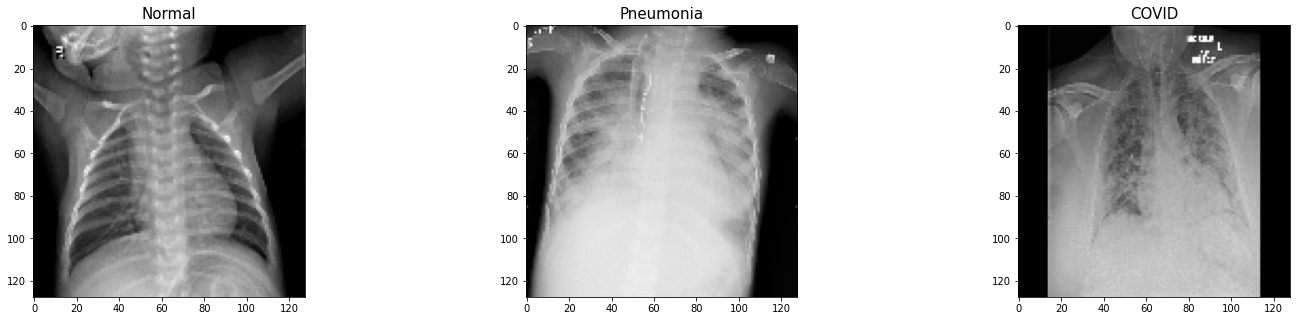

In [0]:
fig, (ax1, ax2,ax3) = plt.subplots(ncols = 3,nrows = 1, figsize = (25,5))
ax1.imshow(X[1500],cmap='gray')
ax2.imshow(X[0],cmap='gray')
ax3.imshow(X[2900],cmap='gray')

ax1.set_title('Normal',fontsize=15)
ax2.set_title('Pneumonia',fontsize=15)
ax3.set_title('COVID',fontsize=15)

plt.show()

# Normalizing and reshaping

In [0]:
X = np.array(X)/255
y = np.array(y)

In [30]:
X.shape

(2905, 128, 128, 3)

# Train Test Split

In [0]:
Xtrain, Xval, ytrain, yval  = train_test_split(X, y, test_size = 0.25, random_state = 42)

In [32]:
Xtrain.shape

(2178, 128, 128, 3)

In [0]:
ycat_val = to_categorical(yval,3)
ycat_train = to_categorical(ytrain,3)

In [34]:
ycat_val.shape

(727, 3)

# Model

In [0]:
modelo_base = InceptionV3(weights='imagenet', include_top= False, input_shape=(128,128,3))

In [36]:
modelo_base.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 63, 63, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 63, 63, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 63, 63, 32)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [0]:
num_classes=3

In [0]:
# Cria a sequência de camadas
add_model = Sequential()

# Adiciona primeiro o modelo base
add_model.add(modelo_base)

# Precisamos de uma camada global de Pooling
add_model.add(GlobalAveragePooling2D())

# Dropout para regularização e evitar overfitting
add_model.add(Dropout(0.5))

# Camada densa na camada final com ativação softmax para previsão das probabilidades das classes
add_model.add(Dense(num_classes, activation = 'softmax'))

In [0]:
add_model.compile(optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'])

In [0]:
# Regra para a redução da taxa de aprendizado
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', patience = 3, verbose = 1, factor = 0.5, min_lr = 0.00001)

In [0]:
image_gen = ImageDataGenerator(rotation_range=20, # rotate the image 20 degrees
                               zoom_range=0.05, # Zoom in by 5% max
                               fill_mode='nearest' # Fill in missing pixels with the nearest filled value
)
image_gen.fit(Xtrain)

In [42]:
results = add_model.fit_generator(image_gen.flow(Xtrain, ycat_train), epochs=100,validation_data=(Xval,ycat_val), callbacks = [reduce_lr])

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/100
69/69 [==============================] - 12s 168ms/step - loss: 0.4447 - accuracy: 0.8531 - val_loss: 1421.4216 - val_accuracy: 0.4635 - lr: 0.0010
Epoch 2/100
69/69 [==============================] - 10s 141ms/step - loss: 0.2016 - accuracy: 0.9399 - val_loss: 21.3001 - val_accuracy: 0.8735 - lr: 0.0010
Epoch 3/100
69/69 [==============================] - 10s 142ms/step - loss: 0.2109 - accuracy: 0.9307 - val_loss: 461.9807 - val_accuracy: 0.4787 - lr: 0.0010
Epoch 4/100
69/69 [==============================] - 10s 142ms/step - loss: 0.3449 - accuracy: 0.9040 - val_loss: 5548.8550 - val_accuracy: 0.4746 - lr: 0.0010
Epoch 5/100
69/69 [==============================] - ETA: 0s - loss: 0.2039 - accuracy: 0.9229
Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
69/69 [==============================] - 10s 143ms/step - loss: 0.2039 - accuracy: 0.9229 - val_loss: 17.7009 - 

In [43]:
add_model.metrics_names

['loss', 'accuracy']

In [0]:
losses = pd.DataFrame(add_model.history.history)

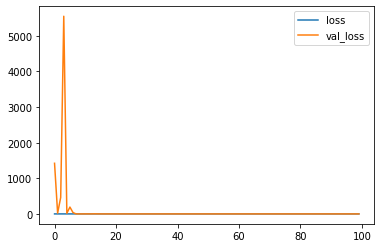

In [45]:
losses[['loss','val_loss']].plot()
plt.show()

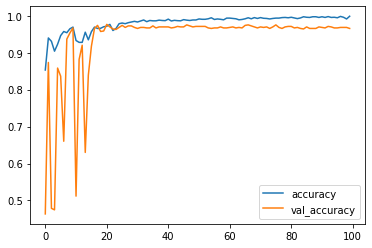

In [46]:
losses[['accuracy','val_accuracy']].plot()
plt.show()

In [47]:
pred = add_model.predict_classes(Xval)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


In [48]:
# 0: Pneumonia
# 1: Normal
# 2: COVID-19

from sklearn.metrics import classification_report
print(classification_report(yval, pred))

              precision    recall  f1-score   support

           0       0.98      0.95      0.96       341
           1       0.96      0.98      0.97       337
           2       0.91      0.98      0.94        49

    accuracy                           0.97       727
   macro avg       0.95      0.97      0.96       727
weighted avg       0.97      0.97      0.97       727



In [49]:
from sklearn.metrics import confusion_matrix
confusion_matrix(yval, pred)

array([[323,  13,   5],
       [  6, 331,   0],
       [  0,   1,  48]])